# DeepSeekQwen蒸馏实战

目标：掌握蒸馏核心流程、代码实现与优化技巧，完成从教师模型到学生模型的完整知识迁移  
前置知识：模型微调、PyTorch基础 

##  第零部分：为什么需要知识蒸馏
#### 一、现实中对小模型的需求非常大
大模型（如GPT、大ResNet）虽然性能高，但计算量大、存储占用高、推理速度慢，不适合在手机、边缘设备、无人机、车载系统等场景下部署，或者在低带宽、低延迟、低功耗等要求下使用。因此我们希望模型能做到更小、更快、更省电，还能保持较好的准确率。
#### 二、小模型直接训练难以获得高性能
小模型结构简单、容量小，直接训练对小模型训练常常会遇到学不“深”、泛化能力弱等问题。而大模型，由于参数量足够大，在训练过程中学到了很多“隐藏的知识”，我们在谈论知识蒸馏的时候，实际上是希望能够通过一种大模型“带”小模型的方式，实现“走捷径”的效果。
#### 三、提高模型的泛化能力和鲁棒性
对小模型使用硬标签进行训练时，容易出现学得死板、不稳定等现象，而蒸馏使用的是软标签（soft targets）将会更平滑，更有“类间知识”，更容易学出泛化能力和稳定性。这种特性，一些数据稀缺、训练困难的任务中将尤其有效。

##  第一部分：理论精讲
### 一、蒸馏技术核心原理


### 1.知识蒸馏定义
知识蒸馏（Knowledge Distillation）是一种模型压缩技术，通过将一个大型预训练模型（教师模型，Teacher Model）的知识迁移到一个较小的模型（学生模型，Student Model）中，从而在保持模型性能的同时减少模型的参数量和计算量。

知识蒸馏的概念最早是由Geoffrey Hinton等人在《[Distilling the Knowledge in a Neural Network](https://arxiv.org/pdf/1503.02531)》一文中提出。

### 2.蒸馏技术的基本原理

<img src="images/教师-学生模型.png" width="800" height="auto">

图片来源：[Knowledge Distillation: A Survey](https://arxiv.org/pdf/2006.05525)

蒸馏技术的核心在于知识的有效传递与压缩，具体来说，就是通过一个训练有素的教师模型，其凭借复杂的结构和大量的参数捕捉到了数据中的深层次模式和特征。学生模型则通过模仿教师模型的输出来学习这些模式和特征，以期达到相近的表现效果。

蒸馏过程通常包含以下几个关键步骤：

1. **教师模型的训练**

首先需要构建并训练一个高性能的教师模型。这个模型往往拥有庞大的参数量和复杂的网络架构，使其能够深入理解和捕捉输入数据中的复杂模式和特征。

2. **数据准备**

从已经训练好的教师模型中抽取推理数据样本。这一阶段的数据不仅包括原始输入数据，还涵盖了教师模型对这些输入产生的预测结果。这些数据将作为后续训练学生模型的基础资料。

3. **学生模型的训练**

利用教师模型生成的输出作为指导信号（即软目标），对学生模型进行训练。这样做的目的是让学生模型学习到教师模型的知识与经验，尽管它的规模更小、结构更为简单。

4. **优化与调整**

在训练过程中，持续优化和调整学生模型的结构和参数，旨在确保它在维持高效运行的同时，尽可能地逼近教师模型的性能表现。这一步骤可能涉及到多种策略，如调整模型大小、改变网络深度或宽度等，以找到最佳平衡点。

通过上述步骤，蒸馏技术能够在减少计算资源消耗和模型复杂度的情况下，依然保持高水平的任务处理能力。这种方法对于推动机器学习模型向更高效、更实用的方向发展具有重要意义。


### 3.蒸馏的常见类型与常用方案
1. **常见类型**
- 基于响应的知识：这种方法依赖于模型输出层提供的软目标，例如各类别的预测概率。这种方式让学生模型不仅学习教师模型的最终分类结果，还能理解其对不同类别的置信度。
- 基于特征的知识：这种类型通过模仿教师模型中间层的特征激活模式来传递知识。这些中间表示能够捕捉输入数据的抽象特征，帮助学生模型学习到更丰富的信息。
- 基于关系的知识：这里关注的是样本之间或特征之间的交互关系，比如它们的相似性或构成的图结构等。该方法试图让学生模型理解数据点间的复杂关系，而不仅仅是单个实例的信息。

<img src="images/常见类型.png" width="800" height="auto">

图片来源：[Knowledge Distillation: A Survey](https://arxiv.org/pdf/2006.05525)

2. **常用方案**
- 离线蒸馏：这是一种传统的两步走策略，首先独立训练一个高性能的教师模型，之后使用这个教师模型去指导学生模型的学习。这种方法相对直接，但需要预先准备好一个有效的教师模型。
- 在线蒸馏：与离线蒸馏不同，在线蒸馏允许教师和学生模型同时进行训练，并相互学习以提高彼此的表现。这种端到端的联合训练方式（例如深度互学习）可以更灵活地调整两个模型之间的知识转移过程。
- 自蒸馏：在没有外部教师模型的情况下，也可以在同一模型内部执行知识迁移。例如，可以让深层网络中的高级层指导低级层的学习，这种方法有助于增强模型内部的知识利用效率，特别适合资源有限的情况。

<img src="images/常用方案.png" width="800" height="auto">

图片来源：[Knowledge Distillation: A Survey](https://arxiv.org/pdf/2006.05525)


### 4.与传统微调的区别
1. **目标不同**：
    - 知识蒸馏：主要目标是将一个大型预训练模型（教师模型）的知识迁移到一个较小的模型（学生模型）中，从而在保持模型性能的同时减少模型的参数量和计算量。
    - 传统微调：主要目标是通过在特定任务数据集上进一步训练预训练模型，以提高模型在该任务上的性能。

2. **方法不同**：
    - 知识蒸馏：通过让学生模型学习教师模型的输出（软标签）和中间层特征，使得学生模型能够在较小的规模下达到与教师模型相近的性能。
    - 传统微调：通过在特定任务数据集上训练模型，调整模型参数以适应新任务。

3. **应用场景不同**：
    - 知识蒸馏：适用于需要在资源受限环境中部署模型的场景，如移动设备或嵌入式系统。
    - 传统微调：适用于需要在特定任务上提高模型性能的场景，如文本分类、图像识别等。

4. **模型结构不同**：
    - 知识蒸馏：通常涉及两个模型，教师模型和学生模型，学生模型通常比教师模型更小。
    - 传统微调：通常只涉及一个模型，通过在特定任务数据集上进一步训练该模型。


### 二、蒸馏关键技术

### 0. 深度学习回顾
为了更好的描述蒸馏的关键技术，我们先简单回顾一下深度学习的基本流程：

<img src="images/深度学习.png" width="800" height="auto">

当输入的向量经过多层网络的计算后，我们得到了一个向量的输出（即logits），这个向量代表了模型的预测结果。这个结果是一个参数化的向量，难以直接解释，因此我们需要将其转换为一个易于解释的向量。
当这个向量经过softmax函数后，我们得到了一个概率分布，这个分布代表了模型对每个类别的预测概率。softmax层起到了一个归一化的作用，使得每个类别的预测概率之和为1。
以下为一种常用的softmax函数：
$$
softmax(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n}e^{z_j}}
$$

通过softmax函数，我们可以将模型的预测结果转换为一个概率分布，从而更好的解释模型的预测结果。


### 1.温度参数（T）
回顾了深度学习和softmax的原理后，我们可以开始讨论知识蒸馏的具体实现了。
我们需要引入soft label和hard label两个概念。
- hard label：就是我们通常所说的标签，比如我们要对图片进行分类，那么标签就是图片的类别。
- soft label：就是我们对标签的一种预测，比如我们要对图片进行分类，那么我们可以对图片进行分类，得到一个概率分布，然后我们就可以对这个概率分布进行蒸馏，得到一个soft label。

下图是一个简单的例子，共有10个标签，左边是一个softmax的输出，右边是一个soft label。

<img src="images/hard_soft.png" width="800" height="auto">

下面的例子可以说明soft label的作用。

<img src="images/5-8.png" width="800" height="auto">

图中两个分布都是对手写图片“5”的预测结果，但是明显有不一样的差别，一个有点像“3”，一个有点像“8”。当我们使用soft label时，这些负标签中也带有大量的信息，就可以更好地保留图像的特点信息，因此使用soft label进行训练可以具有更好的泛化能力。

在知识蒸馏的训练过程中，将使用soft label，使得学生模型可以学习到教师模型的泛化能力，但是，如果直接使用softmax层的输出值作为soft target, 这又会带来一个问题: 当softmax输出的概率分布熵相对较小时，负标签的值都很接近0，对损失函数的贡献非常小，小到可以忽略不计。因此"温度"这个变量就派上了用场。

在原来的softmax函数中引入T参数，对输出的概率分布进行缩放，使得熵变大，从而使得负标签的值变大，对损失函数的贡献变大，从而使得学生模型可以学习到教师模型的泛化能力。

$$
softmax(x)=\frac{e^{x_i/T}}{\sum_{j=1}^{n}e^{x_j/T}}    
$$

下面我们使用代码来看一下T参数对于softmax函数的影响。

原始输出：



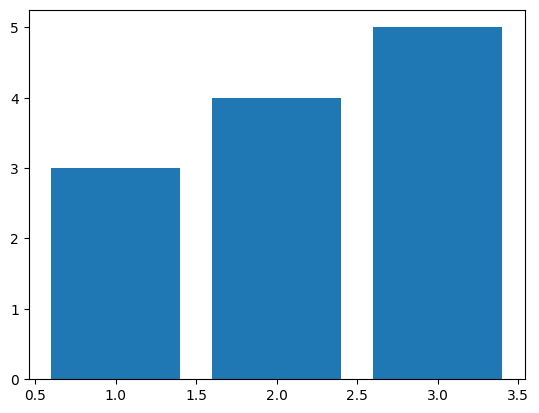

原始softmax结果：



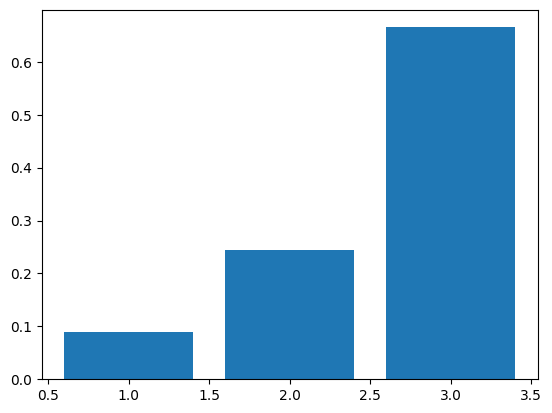

t=2时softmax结果：



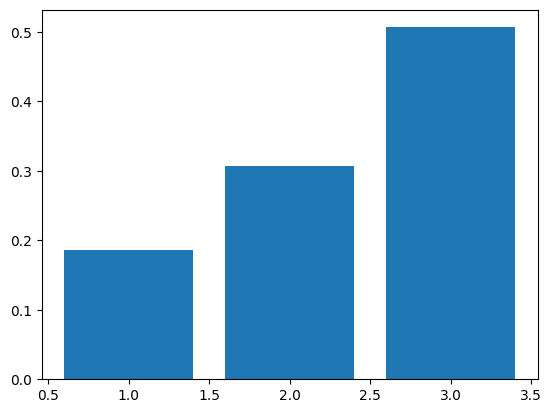

t=0.5时softmax结果：



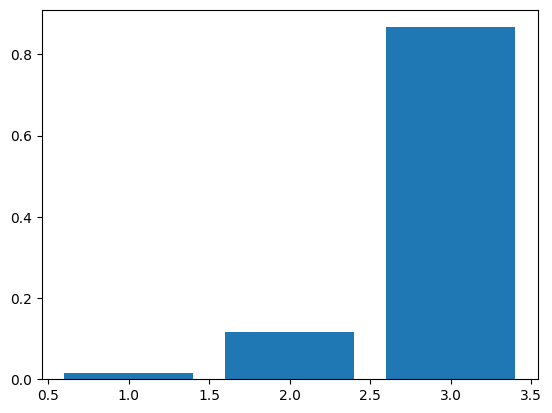

In [14]:
# 通过参数变化，感受T对softmax函数输出的影响，假设模型原始输出为[3,4,5]，画柱状图
import numpy as np
import matplotlib.pyplot as plt

def softmax(x,t):
    x=[i/t for i in x]
    return np.exp(x)/np.sum(np.exp(x),axis=0)

xx=[1,2,3]##横坐标
x = [3,4,5]##原始输出向量

print("原始输出：\n")
plt.bar(xx,x)
plt.show()

y = softmax(x,1)
print("原始softmax结果：\n")
plt.bar(xx,y)
plt.show()

print("t=2时softmax结果：\n")
yy=softmax(x,2)
plt.bar(xx,yy)
plt.show()

print("t=0.5时softmax结果：\n")
yyy=softmax(x,0.5)
plt.bar(xx,yyy)
plt.show()



可以看出，当T=1时，即为原来的softmax函数，当T变大时，模型的输出更加“平均”，这就是softmax函数的“软化”效果，此是，负标签的信息会得到放大，因此模型会更加关注负标签的信息。

### 2.损失函数设计

当我们了解了soft label和hard label的概念后，就可以开始设计蒸馏的训练过程了。所谓设计训练过程，就是指如何将soft label和hard label结合起来，使得模型能够更好地学习。就是说，我们需要设计一个损失函数，使得模型能够更好地学习soft label和hard label之间的关系。

<img src="images/knowledge_distillation.png" width="800" height="auto">

图片来源：[knowledge_distillation](https://intellabs.github.io/distiller/knowledge_distillation.html)

图中展示了蒸馏的训练过程。首先，我们需要准备一个学生模型和一个教师模型。学生模型是一个较小的模型，而教师模型是一个较大的模型，我们假设教师模型已经训练好了，下面主要讨论如何训练学生模型。

我们需要将教师模型的输出，通过一个“高温”操作转换为作为soft label，然后将soft label和hard label结合起来，训练学生模型。如图所示，训练过程中，损失函数应当包括两个部分：一部分是学生模型的损失函数，即学生模型的logits和hard label之间的损失函数，另一部分是soft label和hard label之间的损失函数。具体来说，我们可以使用交叉熵损失函数来计算学生模型的损失函数，然后使用KL散度损失函数来计算soft label和hard label之间的损失函数。





- KL散度。
KL散度是一种用于衡量两个概率分布之间差异的度量。它可以用来比较两个分布的相似性，也可以用来衡量两个分布之间的差异。
KL散度的计算公式如下：
$$
KL(P||Q) = \sum_{x \in X} P(x) \log \frac{P(x)}{Q(x)}
$$
其中，$P$ 和 $Q$ 分别是两个概率分布，$X$ 是它们的支持集。

在知识蒸馏过程中，我们可以使用KL散度来衡量教师模型和学生模型之间的差异。具体来说，我们可以将教师模型的输出作为一个概率分布，将学生模型的输出作为另一个概率分布，然后计算它们之间的KL散度。将其记为：
$$
\mathcal{L}_{\text{KD}} = \sum_{x \in X} Teacher(x) \log \frac{Teacher(x)}{Student(x)}
$$

- 交叉熵。
交叉熵也是一种用于衡量两个概率分布之间差异的度量。它的计算公式如下：
$$
H(P,Q) = -\sum_{x \in X} P(x) \log Q(x)
$$
其中，$P$ 和 $Q$ 分别是两个概率分布，$X$ 是它们的支持集。

在知识蒸馏过程中，我们可以使用交叉熵来衡量学生模型logits与标签值之间的差异。具体来说，我们可以将学生模型的logits作为一个概率分布，将标签值作为另一个概率分布，然后计算它们之间的交叉熵。将其记为：
$$
\mathcal{L}_{\text{CE}} = -\sum_{x \in X} Teacher(x) \log Student(x)
$$

我们需要将这两个损失函数结合起来，得到最终的损失函数。具体来说，我们可以将它们加权求和，得到：
$$
\mathcal{L} = \alpha \mathcal{L}_{\text{KD}} + (1-\alpha) \mathcal{L}_{\text{CE}}
$$
其中，$\alpha$ 是一个超参数，用于控制KL散度和交叉熵的权重。

更多关于KL散度和交叉熵的内容，可以参考以下资料：
[KL散度和交叉熵(Cross Entropy)的联系](https://zhuanlan.zhihu.com/p/389179483)


### 3.中间层对齐

在知识蒸馏（Knowledge Distillation, KD）中，中间层对齐（Intermediate Layer Alignment）是一种扩展传统蒸馏方法的技术，其核心思想是让学生模型不仅模仿教师模型的最终输出，还要模仿其中间层的特征表示。这种方法能更全面地迁移教师模型的“知识”，尤其适用于复杂模型压缩或特征表示学习。

（上面的图中的feature-based knowledge）

中间层对齐有以下特点：

- 更丰富的知识迁移：中间层包含局部特征、空间结构等低级信息，而输出层仅提供高级语义。

- 缓解容量差距问题：当学生模型过小时，仅模仿输出层可能导致欠拟合，中间层指导能提供更细致的优化目标。

- 提升泛化性：中间层特征的对齐可看作一种正则化，防止学生模型过拟合训练标签。

下面介绍一个较为经典的中间层对齐方法，也可以称为特征蒸馏方法，FitNets。

<img src="images/fitnet.png" width="800" height="auto">

图片来源：[FITNETS: HINTS FOR THIN DEEP NETS](https://arxiv.org/pdf/1412.6550)

FitNet的提出是为了解决模型压缩时，对模型深度的利用不足的问题，通过该方法可以从一个“又宽又深”的教师模型，训练出一个“又窄又深”的学生模型，从而实现模型压缩。其基本思想是，先通过教师模型的中间层，对学生模型的中间层进行训练，达到一个类似预先训练的目的，先使学生模型学习老师模型的中间层表达，而后再使用传统知识蒸馏的方法进行蒸馏。

如子图(a)所示，给定一个已经训练好的教师模型和一个随机初始化的学生模型。从教师模型和学生模型中选择一部分进行中间层对齐，教师模型的部分称为hint layer，记为$W_{Hint}$，学生模型的部分称为guided layer，记为$W_{Guided}$。

由于学生模型通常比教师模型“瘦”，因此在学生模型需要加上一个卷积层，论文中称为regressor（回归器），来使学生模型的输出与教师模型一致。
在这一训练学生模型的过程中，损失函数如下定义：

$$
\mathcal{L}_{HT}(W_{Guided}, W_r) = \frac{1}{2} \| u_h(x; W_{Hint}) - r(v_g(x; W_{Guided}); W_r) \|^2
$$

其他中，$W_r$表示学生模型后加上的卷积层，它和学生模型的guided layer一起训练；$u_h$表示hint layer的输出，$v_g$表示guided layer的输出，r表示regressor的输出，损失的计算是教师模型hint的输出与regressor输出的2阶范数。

当Guided layer训练完后，则进入子图(3)所示的第二个阶段，即使用传统的知识蒸馏方法继续进行训练。（图中$\mathcal{L}_{DK}$应为$\mathcal{L}_{KD}$），其具体表示见上一节。


### 三、蒸馏与微调的协同

### 1.场景对比

| 特性/方面          | 蒸馏（Distillation）                                      | 微调（Fine-tuning）                                      |
|-------------------|-----------------------------------------------------------|----------------------------------------------------------|
| **定义**           | 一种知识转移方法，通过训练一个较小的学生模型模仿大型教师模型的行为。 | 在已针对某个任务训练好的模型基础上，为适应新任务或数据集进行的小规模训练调整。 |
| **主要目的**       | 创建一个更加紧凑、高效的模型，同时尽可能保持原始模型的性能。 | 调整现有模型以适应新的任务或数据集，提高在特定领域或任务上的表现。 |
| **适用场景**       | - 资源受限环境，需要降低计算成本。<br>- 提升小模型的表现。<br>- 隐私保护需求。 | - 迁移学习，将模型应用于相关的新任务。<br>- 处理少量标注数据的情况。<br>- 领域适应，当目标领域与预训练模型的领域不完全相同时。 |
| **涉及模型数量**   | 涉及两个模型：教师模型和学生模型。                          | 通常基于单一模型进行调整。                                |
| **训练方式**       | 教师模型指导学生模型的学习过程。                            | 使用新数据对已有模型进行进一步训练。                      |
| **资源消耗**       | 目标是减少资源消耗，尤其是在部署阶段。                      | 可能不需要大量的计算资源，但取决于预训练模型的大小和调整的程度。 |
| **数据依赖**       | 不一定需要大量数据，因为可以从教师模型中提取知识。          | 通常需要至少一部分与目标任务相关的数据来进行有效的调整。    |

### 2.联合应用流程
联合应用蒸馏与微调的过程通常按以下步骤：

1. **预训练大模型**

首先，选择一个适用于广泛任务的大型预训练模型作为起点，以前是bert、resnet这类模型，现在是以deepseek、qwen、llama为代表的各类开源大语言模型。这些模型由于其规模庞大和参数众多，能够捕捉到丰富的特征表示，但同时也需要较高的计算资源来进行训练和部署。

2. **微调优化任务性能**

在选择了合适的预训练模型之后，接下来是针对特定任务对模型进行微调。这一步骤包括：
- 数据准备：收集或标注与目标任务相关的数据集。
- 模型调整：根据目标任务的特点，可能只需要调整模型的最后一层或多层，也可能需要整个模型进行微调。
- 超参数设置：调整学习率、批次大小等超参数以获得更好的性能。
- 评估与迭代：通过验证集评估模型的表现，并根据结果进一步调整模型直至达到满意的性能水平。
此步骤的目标是使预训练模型适应特定的应用场景，提高模型在该任务上的准确性和效率。

3. **蒸馏压缩为小模型**
完成微调后，为了降低部署成本和提高推理速度，可以通过知识蒸馏技术将大型模型的知识转移到一个小得多的模型中。具体步骤如下：
- 教师模型与学生模型的选择：这里，经过微调后的大型模型作为教师模型，而设计一个结构简单、参数数量少的小型模型作为学生模型。
- 知识转移：训练过程中，不仅使用原始标签数据对学生模型进行指导，还利用教师模型的输出（如类别概率分布）来辅助学生模型的学习。这种方法使得学生模型不仅能学习到基本的分类信息，还能模仿教师模型的复杂决策边界。
- 优化与压缩：在保证一定精度损失的前提下，不断调整学生模型的架构和训练策略，力求在性能和大小之间找到最佳平衡点。


通过上述三个步骤——从预训练大模型开始，经过微调优化特定任务的性能，到最后通过蒸馏将模型压缩为更小、更高效的形式——可以在不显著牺牲模型性能的同时，大大降低资源消耗，提高模型部署的灵活性和效率。这种策略特别适合于资源受限的环境或者需要快速响应的应用场景。

### 四、DeepSeek-R1系列的蒸馏

### 1.deepseek-r1论文中的蒸馏

deepseek在推出满血版deepseek-r1后还使用deepseek-r1生成的80万条（800k）数据，对开源模型（qwen、llama）进行微调，得到了许多小尺寸的模型（最小1.5B）。这些小尺寸模型也能拥有较强的推理能力，在推理方面能力得到了显著提升。

deepseek-r1-蒸馏系列，采用的是数据蒸馏的方式，即使用满血版deepseek-r1对给定的问题，生成回答，这些回答包括了满血版的推理思考过程。小尺寸模型仅使用这些数据直接进行SFT训练，便使小尺寸模型的推理能力得到了质的提升。

所谓的数据蒸馏，原先是指对训练数据进行“蒸馏、提纯”等操作，从海量数据中提取出有用的数据，或者从较大的数据集中，获取可以包含绝大多数知识的小数据集，以提高训练效率。在大模型时代，数据蒸馏逐步演化为使用超大规模大模型，如chatgpt、满血deepseek-r1等，对于特定问题，生成详细、丰富的数据，通常是推理数据，用从超大规模大模型中“蒸馏”出来的“精华数据”来训练小模型，可以显著降低数据收集的难度和成本，并且可以用效且快速地提升小尺寸大语言模型的模型能力。这样的训练方式其实也可以说成是一种“模仿学习”，其实和上面讲的传统的“蒸馏训练”有较大区别，要注意辨析区分。但现在讲大模型蒸馏，基本是使用这种数据蒸馏的方式。

deepseek-r1-蒸馏系列采用的策略是简单的“数据蒸馏+SFT”的方式，要注意对网上其他博文的辨析，目前有相当一部分博文是借助大模型生成的，有的甚至说deepseek蒸馏系列模型中使用了中间层对齐的策略，这是大模型联网搜索中常见的数据污染与知识混淆问题。

另外，deepseek-r1的论文中写到，对qwen和llama系列使用了deepseek-r1中2.3.3中的数据，而2.3.3中的数据应该是用来训练R1的数据，这是论文中存在模糊的一个地方。从文字上看，蒸馏系列使用的数据应该就是训练deepseek-r1的数据，但从正常的蒸馏逻辑上看，则应该是由训练完后的deepseek-r1生成的数据来进行训练才是合理的。目前没看到官方对这个问题有进一步的说明，大家在看网上的博文的时候可以注意辨析。

<img src="images/deepseek-r1-paper.png" width="800" height="auto">

--论文：[DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning](https://arxiv.org/pdf/2501.12948)


### 2.李飞飞的s1模型

在deepseek-r1发布后不久，李飞飞团队凭借不到50美元的云计算成本，成功研发出高性价比的推理模型S1。在数学和编程能力测试中，S1的表现与OpenAI的o1、DeepSeek的R1等顶尖模型旗鼓相当。

李飞飞团队采用测试时扩展（test-time,scaling）+数据蒸馏的方法来训练s1。所谓测试时扩展，就是通过增加测试时的计算量，以获得更好的结果，目前比较强的推理模型大都也采用了这种方法。

1. **数据蒸馏部分**

使用gemini Thinking Experimental模型对1000个精心设计的问题，提炼出推理过程和答案，并用这些数据来对基座模型Qwen2.5-32B-Instruct进行微调。这1000个训练样本是从59K个数据中经过不断的筛选留下的。

2. **测试时扩展部分**

微调结束后，在推理过程中，设计了一个名为budget force的方法来控制模型花费的测度时间计算量，核心思想是强制在推理过程中生成特定数据的“thinking tokens”来达到控制推理过程的目的。

对于过长的思考过程，采用强制添加思考结束符的方式来中断思考过程；对于过短的思考过程，采用强制删除思考结束符，并添加“wait”的方式，来继续思考过程。

最终结果显示，1000条训练数据，可以使基座模型在某些测试集上得到显著提升，虽然总体上论文的结果还挺好，但网上不少人批评1000条训练数据中的数据分布不均匀，更像是针对特定任务测试集的专项提升。但其测试时扩展部分采用的budget force仍有一定实用价值。


## 第二部分：实战演练

### 一、环境配置与数据准备
1. 运行环境：使用vllm进行部署。vllm的安装与运行参考[这里](https://docs.vllm.com.cn/en/latest/getting_started/installation.html#)。
2. 模型下载：下载Qwen2.5-1.5B-Instruct模型。
3. 数据准备：准备一个可用的数据集，这里采用的是[中文基于满血DeepSeek-R1蒸馏数据集-110k](https://www.modelscope.cn/datasets/liucong/Chinese-DeepSeek-R1-Distill-data-110k)，具体数据处理见下文。
4. 训练环境：使用llamafactory进行训练。llamafactory的安装与运行参考[这里](https://llamafactory.readthedocs.io/zh-cn/latest/getting_started/installation.html)。



------------------------以下代码中关于模型的训练与部署的部分需在显卡服务器上运行-----------------------------

### 二、蒸馏实战

为了演示deepseek数据蒸馏训练的效果，我们这里使用了开源的数据集[中文基于满血DeepSeek-R1蒸馏数据集-110k](https://www.modelscope.cn/datasets/liucong/Chinese-DeepSeek-R1-Distill-data-110k)。

In [2]:
#!pip install modelscope
!pip install jsonlines

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple


In [ ]:
#数据集下载，更多下载方式，可以参照数据集网页说明
#from modelscope.msdatasets import MsDataset
#ds =  MsDataset.load('Chinese-DeepSeek-R1-Distill-data-110k', subset_name='default', split='train')

我们先看一下这个数据集，这个数据有各类涉及推理，如高考题、数学推理、物理等，我们选择数学推理子集，meta-math/GSM8K_zh，这个数据集有一个唯一解，这样便于我们直观的对比训练的效果。

In [3]:
import jsonlines
repo_names=set()
with jsonlines.open('Chinese-DeepSeek-R1-Distill-data-110k/distill_r1_110k.jsonl') as reader:
    for obj in reader:
        # print(obj)
        input=obj['input']
        content=obj['content']
        reasoning_content=obj['reasoning_content']
        repo_name=obj['repo_name']
        repo_names.add(repo_name)
    
print(repo_names)
    

{'coig/neo', 'ruozhiba/ruozhiba_ruozhiba', 'meta-math/GSM8K_zh', 'Haijian/Advanced-Math', 'xhs/xhs', 'stem_zh/bio', 'human_value/100poison', 'logi_qa/logi-qa', 'exam/kaoyan', 'zhihu/zhihu_score9.0-10_clean_v10', 'EduChat-Math', 'human_value/coig_human', 'stem_zh/med', 'gavinluo/applied_math', 'stem_zh/phy', 'stem_zh/chem', 'exam/coig_exam'}


打印一个meta-math/GSM8K_zh的数据。可以看出最终的答案由一个\boxed{}标签包裹，我们只要提出其中的结果即可。而数据集中的reasoing_content字段就是使用deepseek-R1生成的思考过程。

In [4]:
with jsonlines.open('Chinese-DeepSeek-R1-Distill-data-110k/distill_r1_110k.jsonl')as reader:
    for obj in reader:
        repo_name=obj['repo_name']
        if repo_name=='meta-math/GSM8K_zh':
            input=obj['input']
            content=obj['content']
            reasoning_content=obj['reasoning_content']
            print("input:\n")
            print(input)
            print("content:\n")
            print(content)   
            print("answer:\n")         
            print(content[content.find('boxed'):])
            print("reasoning_content:\n")
            print(reasoning_content)
            break

input:

大瓶芒果汁容量为30盎司，每瓶售价2700比塞塔。小瓶容量为6盎司，每瓶售价600比塞塔。购买一大瓶而不是同样体积的小瓶可以节省多少比塞塔？
content:



购买30盎司的芒果汁时，若选择小瓶，需计算所需数量及总价：  
- **小瓶数量**：30盎司 ÷ 6盎司/瓶 = **5瓶**  
- **小瓶总价**：5瓶 × 600比塞塔/瓶 = **3000比塞塔**  

大瓶直接提供30盎司，价格为**2700比塞塔**。  

**节省金额**：3000比塞塔（小瓶总价） - 2700比塞塔（大瓶价格） = **300比塞塔**  

最终答案：\boxed{300}
answer:

boxed{300}
reasoning_content:

嗯，我现在要解决这个问题，就是买大瓶芒果汁和同样容量的小瓶相比能省多少钱。题目是说，大瓶有30盎司，每瓶2700比塞塔；小瓶是6盎司，每瓶600比塞塔。那么，我需要先算出同样的30盎司用小瓶的话需要多少钱，然后减去大瓶的价格，差价就是节省的钱。对吗？

首先，先确认一下题目中的各个数据。大瓶容量30盎司，价格2700比塞塔。小瓶容量是6盎司，价格600。所以，小瓶每盎司的价格是600比塞塔除以6盎司，等于100比塞塔每盎司？不过可能不需要算单价，直接算总量需要的钱。

我需要计算购买30盎司的小瓶需要多少瓶。因为每小瓶是6盎司，所以30除以6等于5瓶。这样，买5瓶小瓶才能达到30盎司的量，对吧？

接下来，计算这5瓶小瓶的总价。每瓶600，所以5乘600等于多少呢？让我算算，600乘5的话，应该是3000比塞塔。然后大瓶的价格是2700，所以两者的差价就是3000减去2700，等于300比塞塔。所以，买大瓶可以节省300比塞塔？

不过，这里有没有哪里出错了？比如，有没有可能小瓶的包装或者其他费用？题目里好像没有提到其他因素，应该只是单纯的价格和容量。那是不是这样直接计算就可以了？

再复查一遍：大瓶30盎司2700，要和小瓶比较同样30盎司的费用。30盎司需要的小瓶数量是30/6=5瓶。5瓶的价格是5×600=3000。差价是3000-2700=300。所以节省300比塞塔。没错的话，答案应该就是300比塞塔了。对吗？

或者是不是要考虑有没有余数的情况？比如，如果总量不是正好被小瓶容量整除的

我们现在的计划是，对大模型直接生成结果、大模型直接训练后生成结果、大模型使用蒸馏数据进行训练后的结果。

#### (一)直接生成结果

首先，我们让Qwen2.5-1.5B-Instruct直接生成结果，并统计其正确率。

设置一个函数，用来抽取出\boxed{}中的内容。

In [5]:
import re
def match(text):
    pattern=r'\\boxed\{([^}]*)\}'
    matchs=re.search(pattern,text)
    if matchs:
        return matchs.group(1)
    else:
        return None

In [6]:
inputs=[]
contents=[]
answers=[]
train_data=[]

#对数据集进行整理，将各要素分别抽取出来，同步生成后续的大模型直接训练的数据
id=0
with jsonlines.open('Chinese-DeepSeek-R1-Distill-data-110k/distill_r1_110k.jsonl')as reader:
    for obj in reader:
        repo_name=obj['repo_name']
        if repo_name=='meta-math/GSM8K_zh':
            id=id+1
            input=obj['input']
            content=obj['content']
            reasoning_content=obj['reasoning_content']
            answer=match(content)
            inputs.append(input)
            contents.append(content)
            answers.append(answer)
            train_data.append({"id":id,"instruction":"请一步步推理，并把最终答案放到 \\boxed{}。\n","input":input,"output":content})


将大模型直接训练的数据，记为base_sft，保存成llamafactory可以直接读取的格式。只存第1001个以后的数据，因为前1000个要作为测试数据。

In [7]:
import json
with open('lf_data/base_sft.json','w',encoding='utf-8') as f:
    json.dump(train_data[1000:],f,indent=4,ensure_ascii=False)

使用vllm部署Qwen2.5-1.5B-Instruct模型，具体操作见run_qwen.sh。同时在代码端与模型进行通联测试。

In [8]:
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:6666/v1",#或改为大模型服务器的地址
    api_key="token-abc123",
)
# prompt="你好"
# completion = client.chat.completions.create(
#   model="Qwen2.5-1.5B",
#   messages=[
#     {"role": "user", "content":prompt}
#   ]
# )
# print(completion)
# print(completion.choices[0].message.content)

In [ ]:
#输出结果如下
# ChatCompletion(id='chatcmpl-0806313018e04587aa9d03c7b4875802', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='你好！很高兴见到你。请问有什么我可以帮助你的吗？', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None)], created=1745421774, model='Qwen2.5-1.5B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=14, prompt_tokens=45, total_tokens=59, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None)
# 你好！很高兴见到你。请问有什么我可以帮助你的吗？

对数据集中的前1000个数据，直接进行模型测试，但为了便于处理，我们加上了"请一步步推理，并把最终答案放到 \\boxed{}。\n"的指令。这样使直接使用模型进行输出的结果可以以相同的格式输出。

In [ ]:
from tqdm import tqdm
#测试直接生成的方式
count=0
for idx in tqdm(range(len(inputs[:100]))):#有时间可以测1000的
    input=inputs[idx]
    answer=answers[idx]

    for i in range(3):#每组数据测三次，使测试结果更加稳定、准确

        completion = client.chat.completions.create(
        model="Qwen2.5-1.5B",
        messages=[
            {"role": "user", "content":"请一步步推理，并把最终答案放到 \\boxed{}。\n"+input}
        ]
        )
        llm_out=completion.choices[0].message.content
        llm_answer=match(llm_out)
        if llm_answer==answer:
            count=count+1#统计正确个数
            break        
print(count)

In [ ]:
# 输出结果如下
# 100%|██████████| 100/100 [03:49<00:00,  2.29s/it]
# 65

直接生成的准确率大约为65%。

#### (二)大模型直接训练后生成结果
使用（一）中保存下来的训练数据来进行训练，llamafactory的配置llamafactory_train.sh

使用vllm对训练后的模型进行部署并测试，显卡容量充足时，可以直接带lora部署，文件参考run_qwen_base_sft.sh；显卡容量不足时，可以先使用llamafactory进行模型合并，再使用vllm部署，参考llamafactory_exports.sh。。

In [ ]:
from tqdm import tqdm
#测试直接生成的方式
count=0
for idx in tqdm(range(len(inputs[:100]))):
    input=inputs[idx]
    answer=answers[idx]

    for i in range(3):#每组数据测三次，使测试结果更加稳定、准确

        completion = client.chat.completions.create(
        model="Qwen2.5-1.5B-base_sft",
        messages=[
            {"role": "user", "content":"请一步步推理，并把最终答案放到 \\boxed{}。\n"+input}
        ]
        )
        llm_out=completion.choices[0].message.content
        llm_answer=match(llm_out)
        if llm_answer==answer:
            count=count+1#统计正确个数
            break        
print(count)

In [ ]:
#输出结果如下
# 100%|██████████| 100/100 [03:19<00:00,  1.99s/it]
# 78

直接训练的准确率约为78%。

#### (三)大模型使用蒸馏数据进行训练

数据集提供了蒸馏数据训练的版本Chinese-DeepSeek-R1-Distill-data-110k-SFT，我们直接使用，下载方式见上文。

In [ ]:
instructions=[]
inputs=[]
outputs=[]
answers=[]
train_data_dis=[]
# instruction": {"_type": "Value"}, "input": {"_type": "Value"}, "output":
#对数据集进行整理，将各要素分别抽取出来，同步生成后续的大模型直接训练的数据
id=0
with jsonlines.open('Chinese-DeepSeek-R1-Distill-data-110k-SFT/distill_r1_110k_sft.jsonl')as reader:
    for obj in reader:
        repo_name=obj['repo_name']
        if repo_name=='meta-math/GSM8K_zh':
            id=id+1
            instruction=obj['instruction']
            input=obj['input']
            output=obj['output']
            # print('instruction')
            # print(instruction)
            # print('input')
            # print(input)
            # print('output')
            # print(output)
            instructions.append(instruction)
            inputs.append(input)
            outputs.append(output)
            answers.append(match(output))
            train_data_dis.append({"id":id,"instruction":instruction,"input":input,"output":output})


把这个数据存成dis_sft.json。

In [ ]:
import json
with open('lf_data/dis_sft.json','w',encoding='utf-8') as f:
    json.dump(train_data_dis[1000:],f,indent=4,ensure_ascii=False)

使用llamafactory进行训练。并以同样的方式进行测试。

In [ ]:
from tqdm import tqdm
#测试直接生成的方式
count=0
for idx in tqdm(range(len(instructions[:100]))):
    input=instructions[idx]
    answer=answers[idx]

    for i in range(3):#每组数据测三次，使测试结果更加稳定、准确

        completion = client.chat.completions.create(
        model="Qwen2.5-1.5B-dis_sft",
        messages=[
            {"role": "user", "content":"请一步步推理，并把最终答案放到 \\boxed{}。\n"+input}
        ]
        )
        llm_out=completion.choices[0].message.content
        # print(llm_out)
        llm_answer=match(llm_out)
        if llm_answer==answer:
            count=count+1#统计正确个数
            break        
print(count)

In [ ]:
#输出结果如下
# 100%|██████████| 100/100 [03:06<00:00,  1.86s/it]
# 85

经过蒸馏训练的准确率为85%。

<div class="alert alert-warning">
<b>注意：</b>本课件模型过大，请到网盘中下载
    
通过网盘分享的文件：DeepSeek蒸馏模型
链接: https://pan.baidu.com/s/1svKliQn3UVTO3wBFVUScgA?pwd=udsb 提取码: udsb
</div>